In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import seaborn as sns
from scipy.stats import rankdata
from tqdm import tqdm
from pathlib import Path
from uco.data_loader import pivot_df

In [3]:
original_dir = Path('../data/original')
analysis_dir = original_dir / 'analysis'
analysis_dir.mkdir(parents=True, exist_ok=True)

In [4]:
def get_df():
    df = pd.read_csv('../data/raw/sample_submission.csv')
    df = pivot_df(df).reset_index()[['Image']]
    return df

In [ ]:
# Rank images by maximum segmentation pixel value
with h5py.File(original_dir / 'avg-seg-predictions.h5', 'r') as f:
    group_names = [k for k in f.keys() if k != 'average']
    for c in range(4):
        df = get_df()
        for k in tqdm(group_names):
            preds = f[k][:, c, :, :]
            top = preds.max(axis=1).max(axis=1)
            df[k] = rankdata(top)
        df.set_index('Image', inplace=True)
        df['mean'] = df.apply(lambda row: row.mean(), axis=1)
        df['rank'] = rankdata(df['mean'])
        df.to_csv(analysis_dir / f'segmentation-rank-max-c{c}.csv')

In [80]:
# Rank images by count of segmentation pixel values over 0.5
with h5py.File(original_dir / 'avg-seg-predictions.h5', 'r') as f:
    group_names = [k for k in f.keys() if k != 'average']
    for c in range(4):
        df = get_df()
        for k in tqdm(group_names):
            preds = f[k][:, c, :, :]
            # top = preds.max(axis=1).max(axis=1)
            # df[k] = rankdata(top)
            count = (preds > 0.5).sum(axis=1).sum(axis=1)
            df[k] = rankdata(count)
        df.set_index('Image', inplace=True)
        df['mean'] = df.apply(lambda row: row.mean(), axis=1)
        df['rank'] = rankdata(df['mean'])
        df.to_csv(analysis_dir / f'segmentation-rank-count-c{c}.csv')

100%|██████████| 14/14 [08:40<00:00, 37.17s/it]


In [59]:
# Save prediction ranks based on classification models
with h5py.File(original_dir / 'avg-clas-predictions.h5', 'r') as f:
    # group_names = [k for k in f.keys() if k != 'average']
    group_names = ['average']
    for c in range(4):
        df = get_df()
        for k in tqdm(group_names):
            preds = f[k][:, c]
            ranks = rankdata(preds)
            df[k] = ranks
        df.set_index('Image', inplace=True)
        df.columns = ['clas_rank_avg']
        df.to_csv(analysis_dir / f'classification-ranks-c{c}.csv')

100%|██████████| 1/1 [00:00<00:00, 658.14it/s]


0.9516507166599671


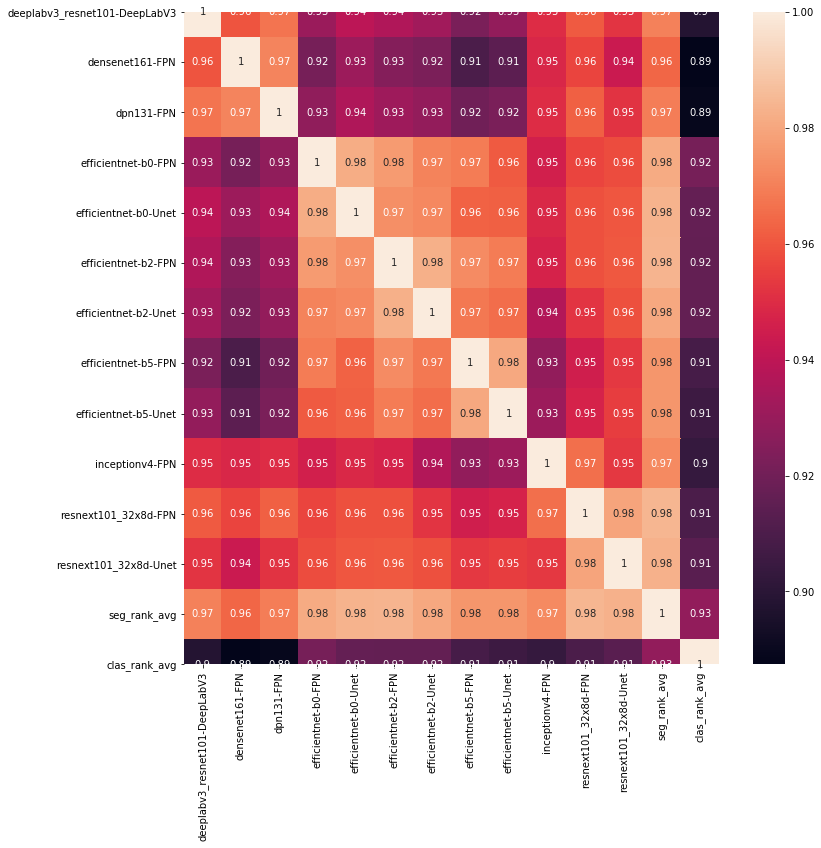

In [86]:
c = 3
fig, ax = plt.subplots(figsize=(12, 12))
df_seg = pd.read_csv(analysis_dir / f'segmentation-rank-count-c{c}.csv').drop([
    'mean', 'rank', 'se_resnet101-FPN', 'se_resnext101_32x4d-FPN'
], axis=1).set_index('Image')
df_seg['seg_rank_avg'] = df_seg.mean(axis=1)
df_clas = pd.read_csv(analysis_dir / f'classification-ranks-c{c}.csv').set_index('Image')
# df_clas['avg_clas_rank'] = df_clas.mean(axis=1)
df = df_seg.join(df_clas)
print(df.corr().mean().mean())
sns.heatmap(df.corr(), annot=True, ax=ax)

0.9678257626160766


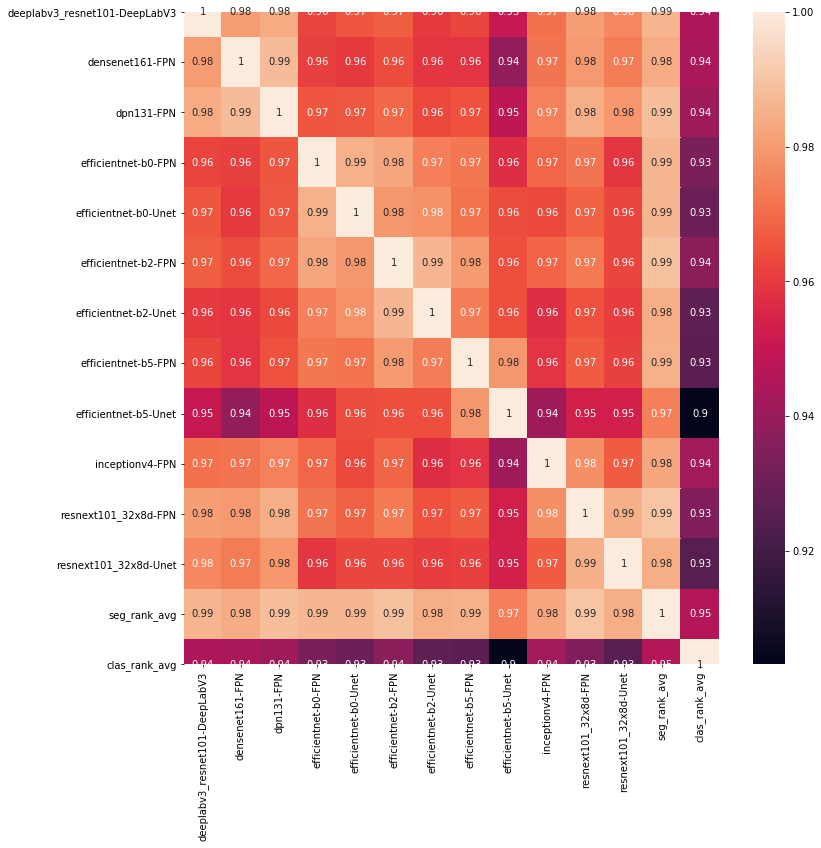

In [79]:
c = 3
fig, ax = plt.subplots(figsize=(12, 12))
df_seg = pd.read_csv(analysis_dir / f'segmentation-rank-max-c{c}.csv').drop([
    'mean', 'rank', 'se_resnet101-FPN', 'se_resnext101_32x4d-FPN'
], axis=1).set_index('Image')
df_seg['seg_rank_avg'] = df_seg.mean(axis=1)
df_clas = pd.read_csv(analysis_dir / f'classification-ranks-c{c}.csv').set_index('Image')
# df_clas['avg_clas_rank'] = df_clas.mean(axis=1)
df = df_seg.join(df_clas)
print(df.corr().mean().mean())
sns.heatmap(df.corr(), annot=True, ax=ax)

In [98]:
dfs = []
for c in range(4):
    # load seg max pixel value ranks, get mean average rank
    df_seg = pd.read_csv(analysis_dir / f'segmentation-rank-max-c{c}.csv').drop([
        'mean', 'rank', 'se_resnet101-FPN', 'se_resnext101_32x4d-FPN'
    ], axis=1).set_index('Image')
    df_seg['seg_rank_avg'] = df_seg.mean(axis=1)
    
    # load clas ranks
    df_clas = pd.read_csv(analysis_dir / f'classification-ranks-c{c}.csv').set_index('Image')
    
    # join and select
    df = df_seg.join(df_clas)[['seg_rank_avg', 'clas_rank_avg']]
    
    # average ranks
    w_seg = 1.0
    w_clas = 0.7
    df[str(c)] = (df['seg_rank_avg'] * w_seg + df['clas_rank_avg'] * w_clas) / (w_seg + w_clas)
    
    # reverse order so rank 1 is highest
    df[str(c)] = rankdata(-df[str(c)])
    
    # append for each class
    dfs.append(df[[str(c)]])
    print(df.head())
    
df = pd.concat(dfs, axis=1)
df.to_csv(original_dir / 'ranks.csv')
df.head()

             seg_rank_avg  clas_rank_avg       0
Image                                           
002f507.jpg    236.208333          145.0  3568.0
0035ae9.jpg   1215.666667         1044.0  2560.0
0038327.jpg   1044.583333         1196.0  2606.0
004f759.jpg   1429.833333         1936.0  2063.0
005ba08.jpg    775.500000          426.0  3096.0
             seg_rank_avg  clas_rank_avg       1
Image                                           
002f507.jpg    442.583333          695.0  3156.0
0035ae9.jpg    626.333333          895.0  2926.0
0038327.jpg   2236.166667         2236.0  1459.0
004f759.jpg   2764.083333         2776.0   943.0
005ba08.jpg    874.208333          797.0  2818.0
             seg_rank_avg  clas_rank_avg       2
Image                                           
002f507.jpg   3622.291667         3672.0    19.0
0035ae9.jpg   3183.583333         2946.0   593.0
0038327.jpg   1835.166667         1249.0  2081.0
004f759.jpg   1218.500000         1187.0  2485.0
005ba08.jpg   3637.2

,0,1,2,3
Image,,,,
002f507.jpg,3568.0,3156.0,19.0,3009.0
0035ae9.jpg,2560.0,2926.0,593.0,1409.0
0038327.jpg,2606.0,1459.0,2081.0,1164.0
004f759.jpg,2063.0,943.0,2485.0,1839.0
005ba08.jpg,3096.0,2818.0,33.0,2863.0


In [66]:
df_select = df[['clas_rank_avg', 'seg_rank_avg']]
df_select['rank_avg'] = (df_select['clas_rank_avg'] + df_select['seg_rank_avg']) / 2
df_select.head()

/home/khornlund/.conda/envs/uco/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clas_rank_avg,seg_rank_avg,rank_avg
Image,,,
002f507.jpg,145.0,236.208333,190.604167
0035ae9.jpg,1044.0,1215.666667,1129.833333
0038327.jpg,1196.0,1044.583333,1120.291667
004f759.jpg,1936.0,1429.833333,1682.916667
005ba08.jpg,426.0,775.500000,600.750000


In [82]:
df_select = df_select[['rank_avg']]
df_select.rank_avg = rankdata(-df_select.rank_avg)
df_select.head()

,rank_avg
Image,
002f507.jpg,3574.0
0035ae9.jpg,2577.0
0038327.jpg,2593.0
004f759.jpg,2014.0
005ba08.jpg,3128.0


In [88]:
df_select.rank_avg.max()

3698.0

In [ ]:
df = get_df()
n_total = np.array([df.shape[0]] * 4)
target_counts = np.array([1864, 1508, 1982, 2382])
clas_cutoff = n_total - target_counts
seg_cutoff = n_total - (target_counts * [0.67, 0.91, 0.625, 0.87]).astype(np.uint32)
print(clas_cutoff, seg_cutoff)

In [ ]:
for c in range(4):
    df_seg  = pd.read_csv(original_dir / f'segmentation-ranks-c{c}.csv')
    df_clas = pd.read_csv(original_dir / f'classification-ranks-c{c}.csv')
    
    avg = rankdata((df_seg['rank'] + df_clas['rank']) / 2)
    df[str(c)] = avg > seg_cutoff[c]
df.to_csv(original_dir / 'selected.csv', index=False)

In [ ]:
df.sum(axis=0)

In [ ]:
df.shape

In [ ]:
df['count'] = df.sum(axis=1)
df.head()

In [ ]:
df_empty = df.loc[df['count'] == 0, :]
df_empty.shape